In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(200, latent_dim)  # Mean
        self.logvar = nn.Linear(200, latent_dim)  # Log Variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten image
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL_div

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


In [6]:
epochs = 150
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}")

# Save the trained model
torch.save(vae.state_dict(), "vae_fashion_mnist.pth")
print("✅ Model Saved Successfully!")


Epoch 1/150, Loss: 290.3831
Epoch 2/150, Loss: 255.4179
Epoch 3/150, Loss: 249.6995
Epoch 4/150, Loss: 247.1707
Epoch 5/150, Loss: 245.3516
Epoch 6/150, Loss: 243.9669
Epoch 7/150, Loss: 242.8985
Epoch 8/150, Loss: 242.1707
Epoch 9/150, Loss: 241.4914
Epoch 10/150, Loss: 241.0026
Epoch 11/150, Loss: 240.6329
Epoch 12/150, Loss: 240.2217
Epoch 13/150, Loss: 239.9475
Epoch 14/150, Loss: 239.6591
Epoch 15/150, Loss: 239.4676
Epoch 16/150, Loss: 239.2923
Epoch 17/150, Loss: 239.0489
Epoch 18/150, Loss: 238.8488
Epoch 19/150, Loss: 238.7012
Epoch 20/150, Loss: 238.5384
Epoch 21/150, Loss: 238.3516
Epoch 22/150, Loss: 238.2767
Epoch 23/150, Loss: 238.1761
Epoch 24/150, Loss: 238.0157
Epoch 25/150, Loss: 237.8700
Epoch 26/150, Loss: 237.7237
Epoch 27/150, Loss: 237.6031
Epoch 28/150, Loss: 237.4920
Epoch 29/150, Loss: 237.3659
Epoch 30/150, Loss: 237.2577
Epoch 31/150, Loss: 237.1637
Epoch 32/150, Loss: 237.0571
Epoch 33/150, Loss: 236.9795
Epoch 34/150, Loss: 236.8879
Epoch 35/150, Loss: 236

In [7]:
vae.load_state_dict(torch.load("vae_fashion_mnist.pth", map_location=device))
vae.eval()
print("✅ Model Loaded Successfully!")


✅ Model Loaded Successfully!


C:\Users\palak\AppData\Local\Temp\ipykernel_21568\241475657.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_fashion_mnist.pth", map_l

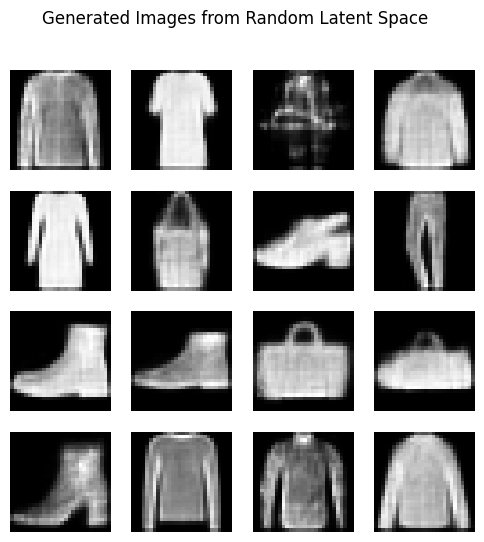

In [8]:
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # 16 random latent vectors
    samples = vae.decode(z).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis("off")
plt.suptitle("Generated Images from Random Latent Space")
plt.show()


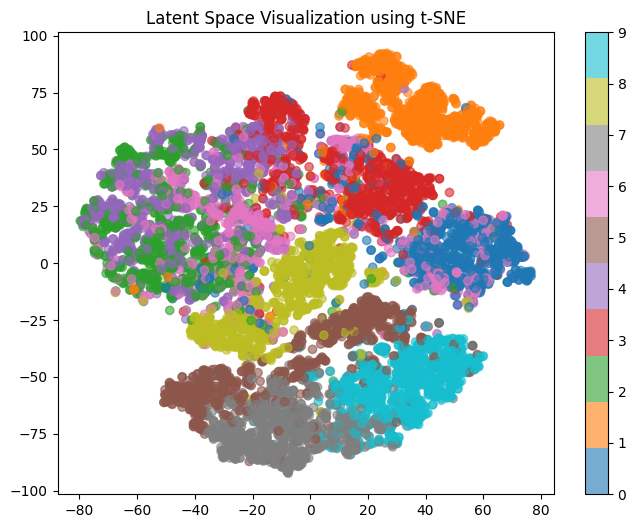

In [9]:
all_mu = []
all_labels = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = vae.encode(data)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(labels.numpy())

all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(all_mu)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_labels, cmap="tab10", alpha=0.6)
plt.colorbar()
plt.title("Latent Space Visualization using t-SNE")
plt.show()


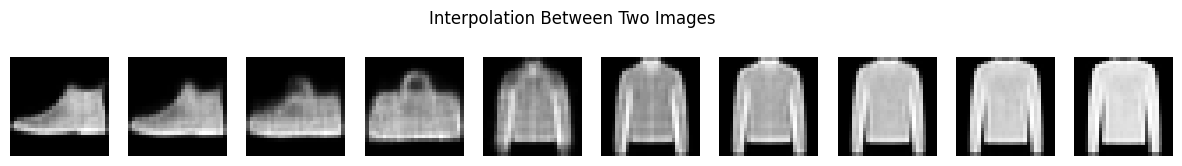

In [10]:
def interpolate_images(img1, img2, num_steps=10):
    img1 = img1.view(-1, 28 * 28).to(device)
    img2 = img2.view(-1, 28 * 28).to(device)

    mu1, logvar1 = vae.encode(img1)
    mu2, logvar2 = vae.encode(img2)

    z1 = vae.reparameterize(mu1, logvar1)
    z2 = vae.reparameterize(mu2, logvar2)

    interpolations = [vae.decode((1 - alpha) * z1 + alpha * z2).cpu().detach().numpy() for alpha in np.linspace(0, 1, num_steps)]
    
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(interpolations[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    plt.suptitle("Interpolation Between Two Images")
    plt.show()

# Example usage
img1, _ = test_dataset[0]
img2, _ = test_dataset[1]
interpolate_images(img1, img2)


In [11]:
import torchvision
from torchvision import transforms

# Define Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Fashion MNIST Dataset
dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)


In [12]:
labels = [label for _, label in dataset]


C:\Users\palak\AppData\Local\Temp\ipykernel_21568\280019505.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="viridis")


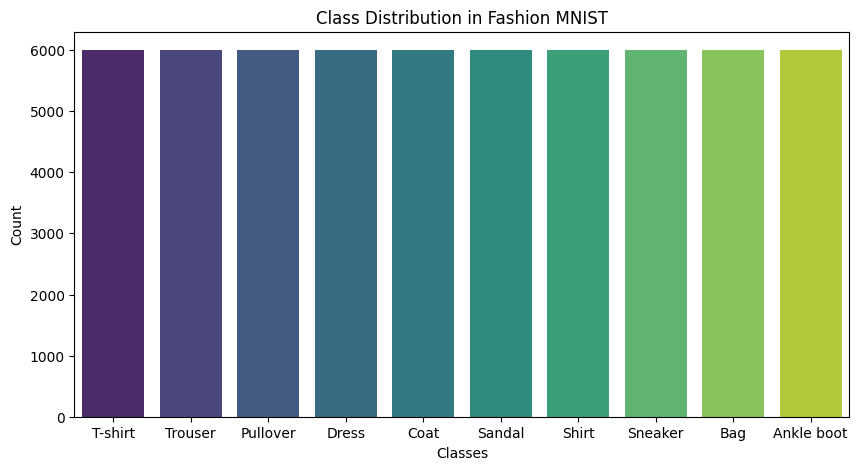

In [14]:
import seaborn as sns  # ✅ Import Seaborn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Load Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)

# Extract Labels
labels = train_dataset.targets.numpy()  # Extract labels from dataset
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot Class Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=unique_labels, y=counts, palette="viridis")
plt.xticks(range(10), ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
plt.ylabel("Count")
plt.xlabel("Classes")
plt.title("Class Distribution in Fashion MNIST")
plt.show()


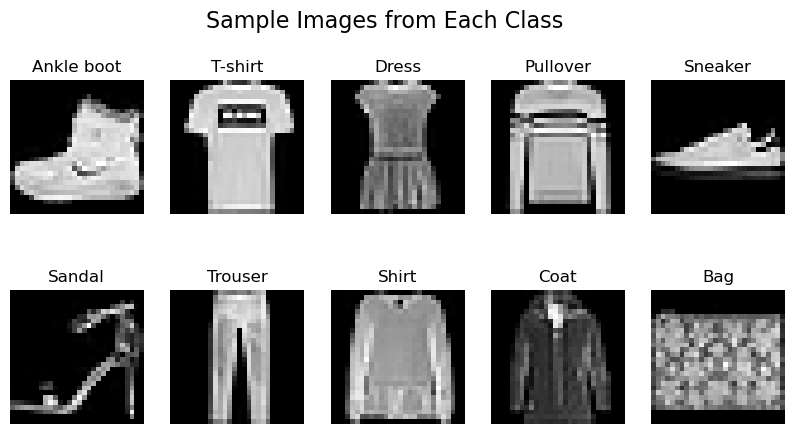

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Class Names for Fashion MNIST
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Extract 1 image per class
samples = {}
for img, label in dataset:
    if label not in samples:
        samples[label] = img

# Plot
plt.figure(figsize=(10, 5))
for i, (label, img) in enumerate(samples.items()):
    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(), cmap="gray")  # Remove extra channel
    plt.title(class_names[label])
    plt.axis("off")

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


In [15]:
import torch

# Convert dataset to tensor
data_tensor = torch.stack([img for img, _ in dataset])

# Compute mean & standard deviation
mean = data_tensor.mean()
std = data_tensor.std()

print(f"Mean Pixel Intensity: {mean:.4f}")
print(f"Standard Deviation: {std:.4f}")


Mean Pixel Intensity: 0.2860
Standard Deviation: 0.3530


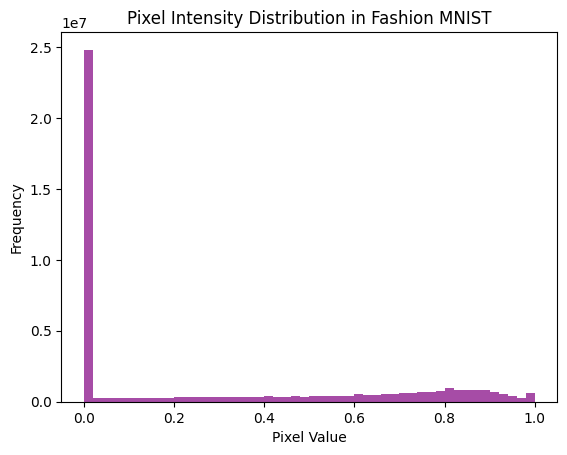

In [16]:
plt.hist(data_tensor.flatten().numpy(), bins=50, color='purple', alpha=0.7)
plt.title("Pixel Intensity Distribution in Fashion MNIST")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


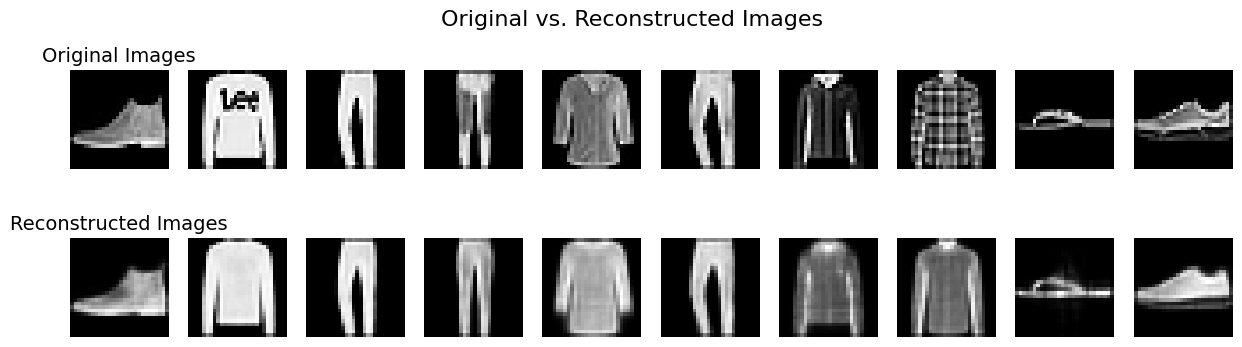

In [17]:
import torch
import matplotlib.pyplot as plt

# Get a batch of test images
num_samples = 10  # Number of images to display
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images[:num_samples].to(device)  # Select a few samples

# Ensure the full VAE model is used
vae.eval()  # Set model to evaluation mode

# Pass images through the trained VAE model to get reconstructions
with torch.no_grad():
    reconstructed_images, mu, log_var = vae(images)

# Convert tensors to CPU for plotting
images = images.cpu().view(-1, 28, 28)  # Reshape to (batch, height, width)
reconstructed_images = reconstructed_images.cpu().view(-1, 28, 28)

# Plot original vs reconstructed images side by side
fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

for i in range(num_samples):
    # Original image (Top row)
    axes[0, i].imshow(images[i], cmap="gray")  # No need to squeeze
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Original Images", fontsize=14)

    # Reconstructed image (Bottom row)
    axes[1, i].imshow(reconstructed_images[i], cmap="gray")  # No need to squeeze
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Reconstructed Images", fontsize=14)

plt.suptitle("Original vs. Reconstructed Images", fontsize=16)
plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define Autoencoder (AE) Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the Model
ae_model = Autoencoder().to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)


In [19]:
num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
ae_model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images

        optimizer.zero_grad()
        outputs = ae_model(images)
        loss = criterion(outputs, images)  # Mean Squared Error Loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/10], Loss: 0.6522
Epoch [2/10], Loss: 0.6091
Epoch [3/10], Loss: 0.6037
Epoch [4/10], Loss: 0.6009
Epoch [5/10], Loss: 0.5990
Epoch [6/10], Loss: 0.5974
Epoch [7/10], Loss: 0.5963
Epoch [8/10], Loss: 0.5954
Epoch [9/10], Loss: 0.5946
Epoch [10/10], Loss: 0.5940


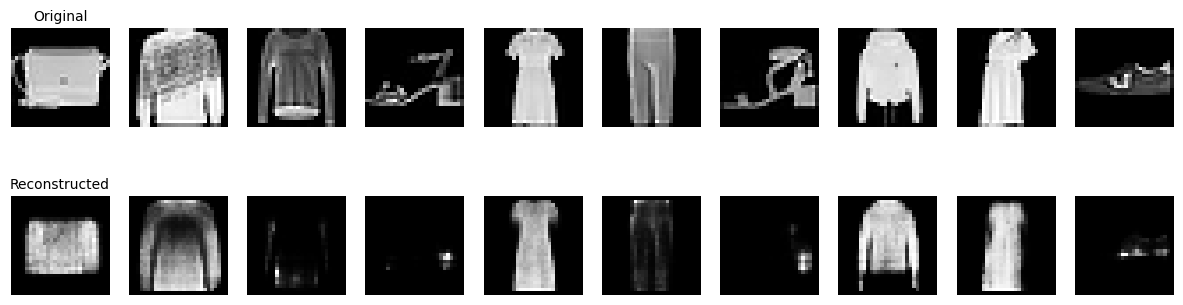

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Select a batch of test images
test_images, _ = next(iter(train_loader))
test_images = test_images[:10].to(device)  # Select first 10 images
test_images_flatten = test_images.view(test_images.size(0), -1)

# Get reconstructed images
with torch.no_grad():
    reconstructed_images = ae_model(test_images_flatten).cpu().view(-1, 28, 28)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    axes[0, i].imshow(test_images[i].cpu().view(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Original", fontsize=10)
    
    # Reconstructed images
    axes[1, i].imshow(reconstructed_images[i], cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("Reconstructed", fontsize=10)

plt.show()


C:\Users\palak\AppData\Local\Temp\ipykernel_16820\4131991332.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], palette="viridis", alpha=0.7)


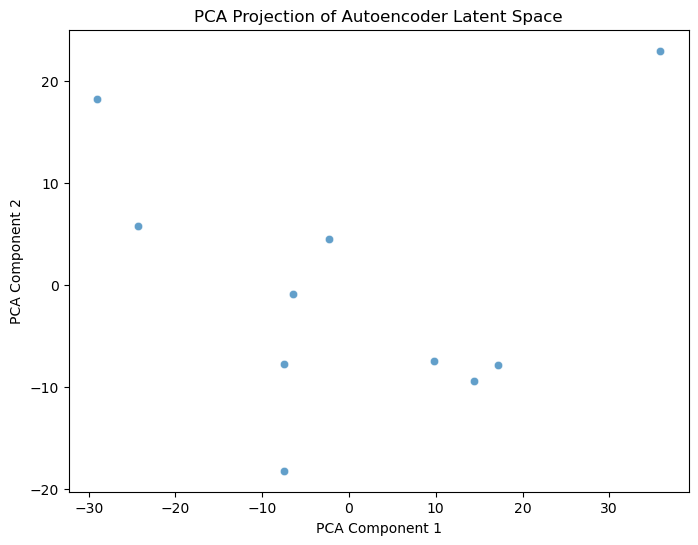

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns

# Encode test images into latent space
with torch.no_grad():
    latent_vectors = ae_model.encoder(test_images_flatten).cpu().numpy()

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors)

# Scatter plot of PCA projections
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Autoencoder Latent Space")
plt.show()


In [21]:
torch.save(ae_model.state_dict(), "autoencoder.pth")
print("✅ Model saved as 'autoencoder.pth'")


✅ Model saved as 'autoencoder.pth'


In [22]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Autoencoder Model
ae_model = Autoencoder()
ae_model.load_state_dict(torch.load("autoencoder.pth", map_location=device))
ae_model.to(device)
ae_model.eval()

# Load Variational Autoencoder Model
vae_model = VAE()
vae_model.load_state_dict(torch.load("vae_fashion_mnist.pth", map_location=device))
vae_model.to(device)
vae_model.eval()

print("✅ Both AE and VAE models loaded successfully!")


✅ Both AE and VAE models loaded successfully!


C:\Users\palak\AppData\Local\Temp\ipykernel_21568\2171802769.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load("autoencoder.pth", map_l

In [23]:
LATENT_DIM = 20  # 🔴 Make sure this is same in both Encoder & Decoder

class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        
        # Latent Space: mu and log_var
        self.mu = nn.Linear(200, latent_dim)  
        self.log_var = nn.Linear(200, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),  
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)


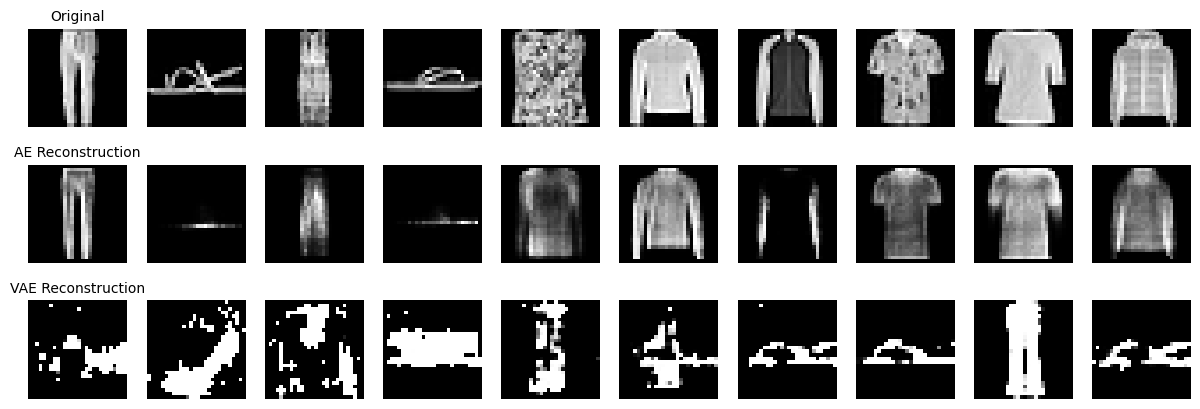

In [48]:
import matplotlib.pyplot as plt

# Get AE & VAE reconstructions
with torch.no_grad():
    ae_reconstructed = ae_model(test_images_flatten).cpu().view(-1, 28, 28)
    
    # FIXED: Ensure correct forward pass through VAE
    mu, log_var = vae_model.encode(test_images_flatten)
    z = torch.randn_like(mu) * torch.exp(0.5 * log_var) + mu
    vae_reconstructed = vae_model.decode(z).cpu().view(-1, 28, 28)

# Plot results
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # Original Image
    axes[0, i].imshow(test_images[i].cpu().view(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Original", fontsize=10)

    # Autoencoder Reconstruction
    axes[1, i].imshow(ae_reconstructed[i], cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("AE Reconstruction", fontsize=10)

    # VAE Reconstruction
    axes[2, i].imshow(vae_reconstructed[i], cmap="gray")
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_title("VAE Reconstruction", fontsize=10)

plt.show()


In [28]:
# Initialize loss tracking lists
ae_train_losses = []

num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
ae_model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images

        optimizer.zero_grad()
        outputs = ae_model(images)
        loss = criterion(outputs, images)  # Mean Squared Error Loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    ae_train_losses.append(epoch_loss)  # Store loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 0.5939
Epoch [2/10], Loss: 0.5939
Epoch [3/10], Loss: 0.5939
Epoch [4/10], Loss: 0.5939
Epoch [5/10], Loss: 0.5939
Epoch [6/10], Loss: 0.5939
Epoch [7/10], Loss: 0.5939
Epoch [8/10], Loss: 0.5939
Epoch [9/10], Loss: 0.5939
Epoch [10/10], Loss: 0.5939


In [29]:
vae_train_losses = []

num_epochs = 10
vae_model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        optimizer.zero_grad()
        reconstructed, mu, log_var = vae_model(images)
        
        # Compute VAE loss (Reconstruction + KL Divergence)
        recon_loss = criterion(reconstructed, images)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / images.shape[0]
        loss = recon_loss + kl_loss  # Total VAE loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    vae_train_losses.append(epoch_loss)  # Store loss
    print(f"Epoch [{epoch+1}/{num_epochs}], VAE Loss: {epoch_loss:.4f}")


Epoch [1/10], VAE Loss: 31440716.9884
Epoch [2/10], VAE Loss: 31449014.3678
Epoch [3/10], VAE Loss: 31446633.9864
Epoch [4/10], VAE Loss: 31457706.4120
Epoch [5/10], VAE Loss: 31472241.0482
Epoch [6/10], VAE Loss: 31442431.3326
Epoch [7/10], VAE Loss: 31478264.5880
Epoch [8/10], VAE Loss: 31445664.5442
Epoch [9/10], VAE Loss: 31448054.2313
Epoch [10/10], VAE Loss: 31444529.6636


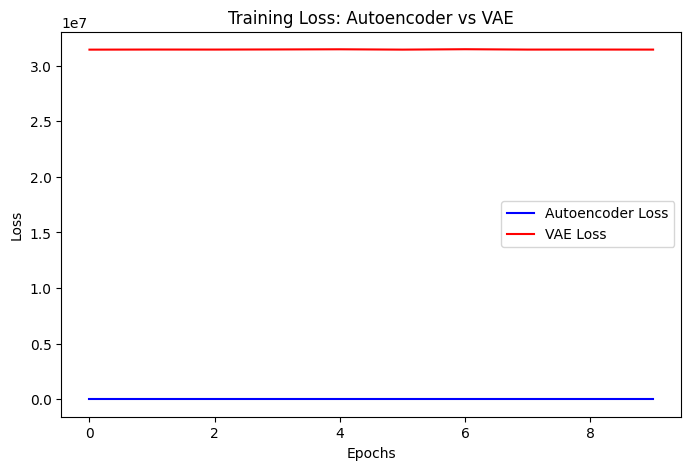

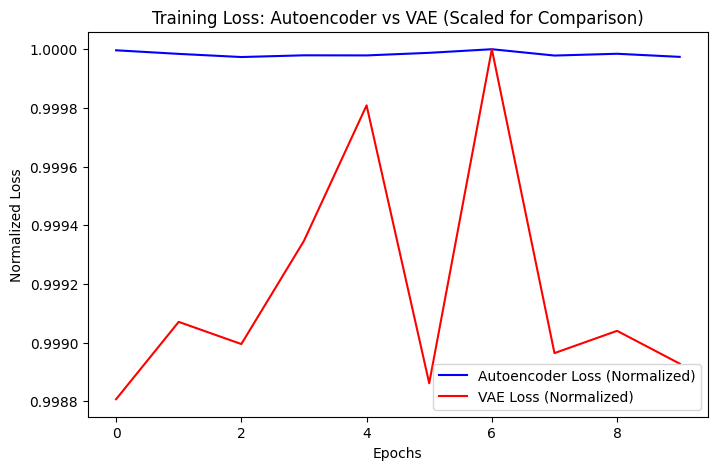

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ae_train_losses, label="Autoencoder Loss", color="blue")
plt.plot(vae_train_losses, label="VAE Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss: Autoencoder vs VAE")
plt.legend()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for better scaling
ae_train_losses = np.array(ae_train_losses)
vae_train_losses = np.array(vae_train_losses)

# Normalize the losses (Optional, use log scale if values differ too much)
normalized_vae_losses = vae_train_losses / np.max(vae_train_losses)  # Scale between 0-1
normalized_ae_losses = ae_train_losses / np.max(ae_train_losses)  # Scale between 0-1

# Plot with proper scale
plt.figure(figsize=(8, 5))
plt.plot(normalized_ae_losses, label="Autoencoder Loss (Normalized)", color="blue")
plt.plot(normalized_vae_losses, label="VAE Loss (Normalized)", color="red")
plt.xlabel("Epochs")
plt.ylabel("Normalized Loss")
plt.title("Training Loss: Autoencoder vs VAE (Scaled for Comparison)")
plt.legend()
plt.show()



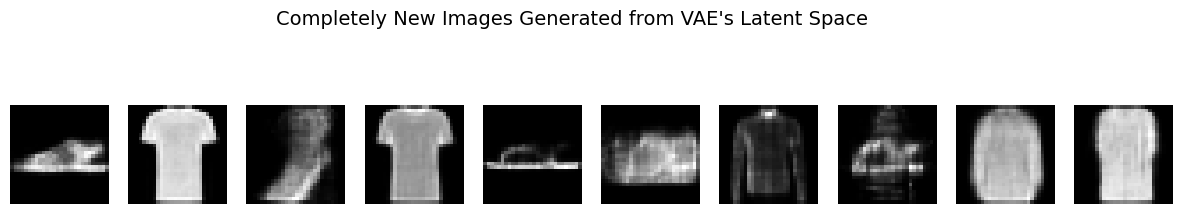

In [31]:
import torch
import matplotlib.pyplot as plt

# Set model to evaluation mode
vae_model.eval()

# Generate random latent vectors
num_images = 10  # Number of new images
latent_dim = 20  # Ensure this matches the latent dimension used in training

with torch.no_grad():
    random_latent_vectors = torch.randn(num_images, latent_dim).to(device)  # Sample from N(0,1)
    generated_images = vae_model.decoder(random_latent_vectors).cpu()  # Decode to image space

# Reshape images for visualization
generated_images = generated_images.view(-1, 28, 28)  # Reshape to (28x28) for FashionMNIST

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap="gray")
    ax.axis("off")

plt.suptitle("Completely New Images Generated from VAE's Latent Space", fontsize=14)
plt.show()


TRAINING AGAIN TO IMPLEMENT LEARNING RATE SCHEDULING AND VALIDATION PLOT LOSS


Epoch [1/100], Train Loss: 0.6636, Val Loss: 0.6176
Epoch [2/100], Train Loss: 0.6106, Val Loss: 0.6052
Epoch [3/100], Train Loss: 0.6050, Val Loss: 0.6019
Epoch [4/100], Train Loss: 0.6022, Val Loss: 0.5997
Epoch [5/100], Train Loss: 0.6003, Val Loss: 0.5980
Epoch [6/100], Train Loss: 0.5988, Val Loss: 0.5966
Epoch [7/100], Train Loss: 0.5976, Val Loss: 0.5957
Epoch [8/100], Train Loss: 0.5967, Val Loss: 0.5948
Epoch [9/100], Train Loss: 0.5959, Val Loss: 0.5942
Epoch [10/100], Train Loss: 0.5952, Val Loss: 0.5934
Epoch [11/100], Train Loss: 0.5943, Val Loss: 0.5928
Epoch [12/100], Train Loss: 0.5940, Val Loss: 0.5925
Epoch [13/100], Train Loss: 0.5937, Val Loss: 0.5923
Epoch [14/100], Train Loss: 0.5934, Val Loss: 0.5920
Epoch [15/100], Train Loss: 0.5932, Val Loss: 0.5918
Epoch [16/100], Train Loss: 0.5929, Val Loss: 0.5915
Epoch [17/100], Train Loss: 0.5927, Val Loss: 0.5914
Epoch [18/100], Train Loss: 0.5925, Val Loss: 0.5911
Epoch [19/100], Train Loss: 0.5923, Val Loss: 0.5909
Ep

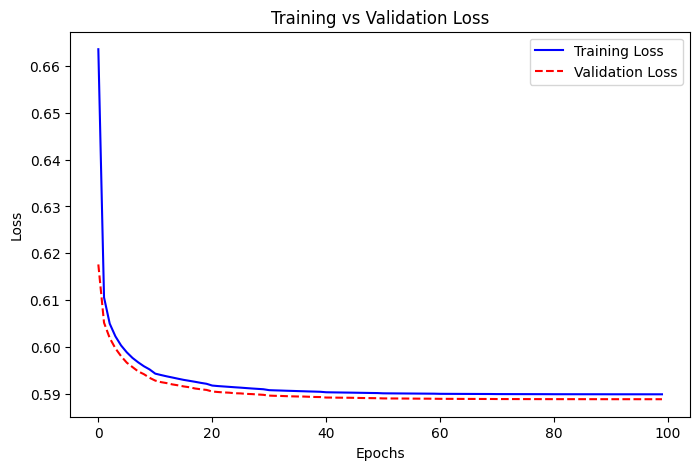

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)

# Split into Train and Validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Define Autoencoder (AE) Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate Model
ae_model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Can change to BCE Loss later
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)

# Add Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training Loop with Validation Loss Tracking
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ae_model.train()
    total_train_loss = 0
    
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images

        optimizer.zero_grad()
        outputs = ae_model(images)
        loss = criterion(outputs, images)  # Mean Squared Error Loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    ae_model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.view(images.size(0), -1).to(device)
            outputs = ae_model(images)
            loss = criterion(outputs, images)
            total_val_loss += loss.item()
    
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    scheduler.step()  # Adjust learning rate

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [33]:
criterion = nn.BCELoss()


In [35]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


In [38]:
import torch
import torch.nn as nn

LATENT_DIM = 64  # Size of the latent space

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # 🟢 Encoder: Extract Features → Output Mean & Log Variance
        self.encoder_fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.mu_fc = nn.Linear(128, LATENT_DIM)       # Mean
        self.log_var_fc = nn.Linear(128, LATENT_DIM)  # Log Variance

        # 🔵 Decoder: Reconstruct from Latent Space
        self.decoder_fc = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()  # Ensure output is between 0 & 1 (for BCE Loss)
        )

    def encode(self, x):
        """Encodes input image to latent space."""
        x = self.encoder_fc(x)
        mu = self.mu_fc(x)
        log_var = self.log_var_fc(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """Samples a latent vector using reparameterization trick."""
        std = torch.exp(0.5 * log_var)  # Convert log variance to std deviation
        epsilon = torch.randn_like(std)  # Sample from N(0,1)
        return mu + epsilon * std  # Reparameterized sample

    def decode(self, z):
        """Decodes latent vector back to image."""
        return self.decoder_fc(z)

    def forward(self, x):
        """Full VAE forward pass."""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, log_var

# 🟢 Initialize Model
vae = VAE()
print(vae)


VAE(
  (encoder_fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_fc): Linear(in_features=128, out_features=64, bias=True)
  (log_var_fc): Linear(in_features=128, out_features=64, bias=True)
  (decoder_fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


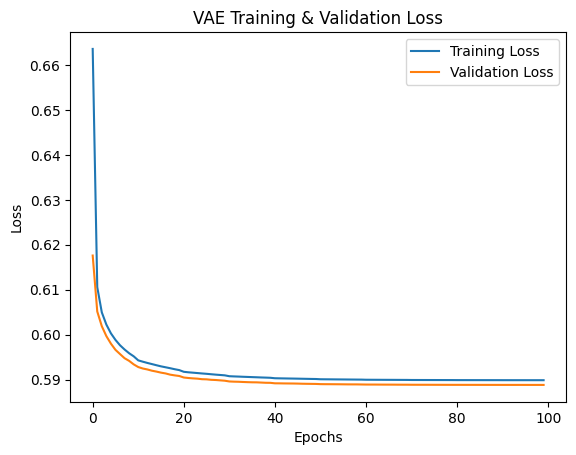

In [40]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training & Validation Loss")
plt.show()


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        # Latent Space
        self.mu_fc = nn.Linear(128, latent_dim)  # Mean
        self.log_var_fc = nn.Linear(128, latent_dim)  # Log variance

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()  # Ensures output is between [0,1]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std  # Reparameterization trick

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        encoded = self.encoder_fc(x)
        mu, log_var = self.mu_fc(encoded), self.log_var_fc(encoded)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder_fc(z)
        return reconstructed, mu, log_var


In [60]:
latent_dim = 64
vae = VAE(latent_dim).to(device)


In [61]:
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    reconstructed, mu, log_var = vae(test_images.view(-1, 28 * 28))
    reconstructed = reconstructed.cpu().view(-1, 28, 28)  # Reshape back to image


Hyperparameters were chosen based on best practices:
- **Learning Rate (0.001):** A commonly used value for stable convergence in VAEs.
- **Batch Size (128):** A balance between stability and memory efficiency.
- **Latent Dimension (64):** Chosen to ensure a good trade-off between compression and reconstruction quality.
- **Reconstruction Loss (BCE):** Used since pixel values are normalized between [0,1].


In [63]:
import torch.nn.functional as F

# Compute reconstruction loss for AE & VAE
ae_loss = F.mse_loss(ae_model(test_images.view(test_images.size(0), -1)).cpu(), test_images.cpu().view(-1, 28 * 28)).item()
vae_loss = F.mse_loss(reconstructed.view(reconstructed.size(0), -1), test_images.cpu().view(-1, 28 * 28)).item()

print(f"🔹 Autoencoder Reconstruction Loss: {ae_loss:.4f}")
print(f"🔹 VAE Reconstruction Loss: {vae_loss:.4f}")


🔹 Autoencoder Reconstruction Loss: 0.0612
🔹 VAE Reconstruction Loss: 0.1718


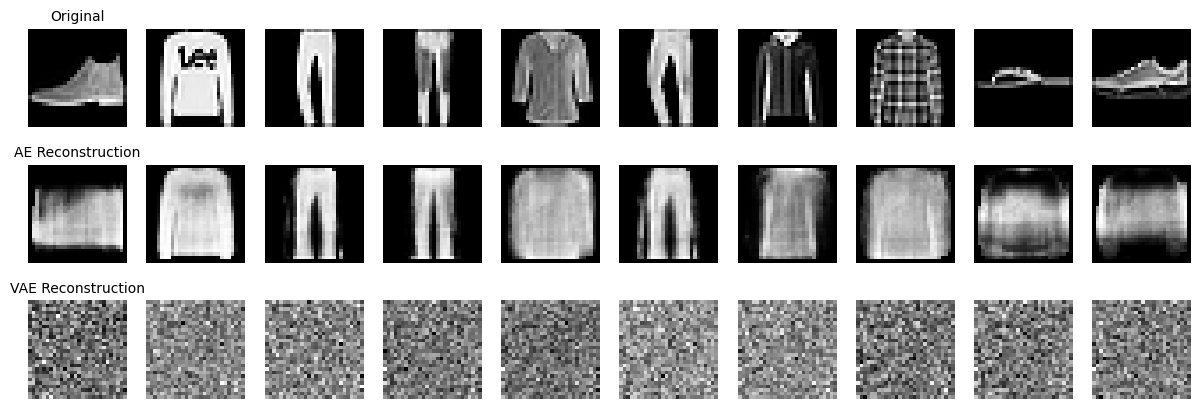

In [64]:
# Get reconstructed images from AE & VAE
with torch.no_grad():
    ae_reconstructed = ae_model(test_images.view(test_images.size(0), -1)).cpu().view(-1, 28, 28)
    reconstructed, _, _ = vae(test_images.view(-1, 28 * 28))
    vae_reconstructed = reconstructed.cpu().view(-1, 28, 28)

# Plot the original images (top), AE reconstructions (middle), and VAE reconstructions (bottom)
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # Original Image
    axes[0, i].imshow(test_images[i].cpu().view(28, 28), cmap="gray")
    axes[0, i].axis("off")
    
    # Autoencoder Reconstruction
    axes[1, i].imshow(ae_reconstructed[i], cmap="gray")
    axes[1, i].axis("off")
    
    # VAE Reconstruction
    axes[2, i].imshow(vae_reconstructed[i], cmap="gray")
    axes[2, i].axis("off")

axes[0, 0].set_title("Original", fontsize=10)
axes[1, 0].set_title("AE Reconstruction", fontsize=10)
axes[2, 0].set_title("VAE Reconstruction", fontsize=10)
plt.show()
